# Not Using Pauli Frame Update

In [1]:
from qiskit import __version__
print(__version__)

2.1.1


In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.quantum_info import Statevector, state_fidelity, partial_trace, DensityMatrix, Pauli
from qiskit.quantum_info.operators import Operator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import transpile 
import numpy as np
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit.circuit.controlflow import IfElseOp
from qiskit.circuit.library import XGate, ZGate
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
import importlib
import steane_ec_decoder2
importlib.reload(steane_ec_decoder2)
from steane_ec_decoder2 import lookup, transversal_cz_lookup

In [4]:
# Custom Hadamard 
h_sub = QuantumCircuit(1, name='H_custom')
h_sub.h(0)
H_custom = h_sub.to_gate()

# Custom CNOT 
cx_sub = QuantumCircuit(2, name='CX_custom')
cx_sub.cx(0, 1)
CX_custom = cx_sub.to_gate()

# Custom CZ
cz_sub = QuantumCircuit(2, name='CZ_custom')
cz_sub.cz(0, 1)
CZ_custom = cz_sub.to_gate()

In [5]:
theta = np.arctan(np.sqrt((np.sqrt(5) - 1) / 2))
amp_0 = np.cos(theta/2)
amp_1 = np.sin(theta/2)

# Function for Encoding

In [6]:
def encoding(qc: QuantumCircuit, first_qubit: int):
    qc.initialize([amp_0, amp_1], first_qubit)
    for i in range(7):
        qc.id(first_qubit+i)
    for i in range(4, 7):
        qc.h(first_qubit+i)
    qc.cx(first_qubit, first_qubit+1)
    qc.cx(first_qubit, first_qubit+2)
    qc.cx(first_qubit+6, first_qubit)
    qc.cx(first_qubit+6, first_qubit+1)
    qc.cx(first_qubit+5, first_qubit)
    qc.cx(first_qubit+6, first_qubit+3)
    qc.cx(first_qubit+5, first_qubit+2)
    qc.cx(first_qubit+4, first_qubit+1)
    qc.cx(first_qubit+5, first_qubit+3)
    qc.cx(first_qubit+4, first_qubit+2)
    qc.cx(first_qubit+4, first_qubit+3)

In [7]:
def perfect_encoding(qc: QuantumCircuit, first_qubit: int):
    qc.initialize([amp_0, amp_1], first_qubit)
    for i in range(4, 7):
        qc.append(H_custom, [first_qubit+i])
    qc.append(CX_custom, [first_qubit, first_qubit+1])
    qc.append(CX_custom, [first_qubit, first_qubit+2])
    qc.append(CX_custom, [first_qubit+6, first_qubit])
    qc.append(CX_custom, [first_qubit+6, first_qubit+1])
    qc.append(CX_custom, [first_qubit+5, first_qubit])
    qc.append(CX_custom, [first_qubit+6, first_qubit+3])
    qc.append(CX_custom, [first_qubit+5, first_qubit+2])
    qc.append(CX_custom, [first_qubit+4, first_qubit+1])
    qc.append(CX_custom, [first_qubit+5, first_qubit+3])
    qc.append(CX_custom, [first_qubit+4, first_qubit+2])
    qc.append(CX_custom, [first_qubit+4, first_qubit+3])

# Functions for Logical |0> and Logical |+>

In [8]:
def logical_zero(qc: QuantumCircuit, first_qubit: int):
    for i in [0, 1, 3]:
        qc.append(H_custom, [first_qubit+i])
    
    qc.append(CX_custom, [first_qubit, first_qubit+4])
    qc.append(CX_custom, [first_qubit+1, first_qubit+2])
    qc.append(CX_custom, [first_qubit+3, first_qubit+5])
    qc.append(CX_custom, [first_qubit, first_qubit+6])
    qc.append(CX_custom, [first_qubit+3, first_qubit+4])
    qc.append(CX_custom, [first_qubit+1, first_qubit+5])
    qc.append(CX_custom, [first_qubit, first_qubit+2])
    qc.append(CX_custom, [first_qubit+5, first_qubit+6])

In [9]:
def logical_plus(qc: QuantumCircuit, first_qubit: int):
    logical_zero(qc, first_qubit)
    for i in range(7):
        qc.append(H_custom, [first_qubit+i])

# Functions for Stabilizer Extraction 

In [10]:
def unflag(qc: QuantumCircuit, first_qubit: int, c1: ClassicalRegister, c2: ClassicalRegister):
    logical_plus(qc, first_qubit+7)
    
    for i in range(7):
        qc.cx(first_qubit+i, first_qubit+i+7)
    qc.measure([first_qubit+7, first_qubit+8, first_qubit+9, first_qubit+10, first_qubit+11, first_qubit+12, first_qubit+13], c1)
    
    qc.reset([first_qubit+7, first_qubit+8, first_qubit+9, first_qubit+10, first_qubit+11, first_qubit+12, first_qubit+13])
    
    logical_zero(qc, first_qubit+7)
    
    for i in range(7):
        qc.cx(first_qubit+i+7, first_qubit+i)
        qc.h(first_qubit+i+7)
    qc.measure([first_qubit+7, first_qubit+8, first_qubit+9, first_qubit+10, first_qubit+11, first_qubit+12, first_qubit+13], c2)

In [11]:
def flag(qc: QuantumCircuit, first_qubit: int, c: ClassicalRegister):
    for i in [first_qubit+7, first_qubit+11, first_qubit+12]:
        qc.h(i)
        
    qc.cx(first_qubit+7, first_qubit+4)
    qc.cx(first_qubit+6, first_qubit+8)
    qc.cx(first_qubit+5, first_qubit+9)
    qc.cx(first_qubit+7, first_qubit+9)
    qc.cx(first_qubit+7, first_qubit)
    qc.cx(first_qubit+4, first_qubit+8)
    qc.cx(first_qubit+1, first_qubit+9)
    qc.cx(first_qubit+7, first_qubit+2)
    qc.cx(first_qubit+3, first_qubit+8)
    qc.cx(first_qubit+6, first_qubit+9)
    qc.cx(first_qubit+7, first_qubit+8)
    qc.cx(first_qubit+7, first_qubit+6)
    qc.cx(first_qubit+5, first_qubit+8)
    qc.cx(first_qubit+2, first_qubit+9)
    
    qc.cx(first_qubit+4, first_qubit+10)
    qc.cx(first_qubit+11, first_qubit+6)
    qc.cx(first_qubit+12, first_qubit+5)
    qc.cx(first_qubit+12, first_qubit+10)
    qc.cx(first_qubit, first_qubit+10)
    qc.cx(first_qubit+11, first_qubit+4)
    qc.cx(first_qubit+12, first_qubit+1)
    qc.cx(first_qubit+2, first_qubit+10)
    qc.cx(first_qubit+11, first_qubit+3)
    qc.cx(first_qubit+12, first_qubit+6)
    qc.cx(first_qubit+11, first_qubit+10)
    qc.cx(first_qubit+6, first_qubit+10)
    qc.cx(first_qubit+11, first_qubit+5)
    qc.cx(first_qubit+12, first_qubit+2)
    
    for i in [first_qubit+7, first_qubit+11, first_qubit+12]:
        qc.h(i)
    
    qc.measure([first_qubit+7, first_qubit+8, first_qubit+9, first_qubit+10, first_qubit+11, first_qubit+12], c)

# Function for QEC

In [12]:
def QEC(qc: QuantumCircuit, first_qubit: int, c: ClassicalRegister, c1: ClassicalRegister, c2: ClassicalRegister):
    flag(qc, first_qubit, c)
    qc.reset([first_qubit+7, first_qubit+8, first_qubit+9, first_qubit+10, first_qubit+11, first_qubit+12])
    
    # Path 1: if c is all 0, then do nothing
    path1 = QuantumCircuit(14)
    path1.add_register(c, c1, c2)
    # Path 2: if c is anything else
    path2 = QuantumCircuit(14)
    path2.add_register(c, c1, c2)
    unflag(path2, first_qubit, c1, c2)
    
    first_if = IfElseOp((c, 0), true_body=path1, false_body=path2)
    qc.append(first_if, list(range(14)), c[:] + c1[:] + c2[:])

# Encoding + 1 Round of EC

In [46]:
ideal = QuantumCircuit(7)
perfect_encoding(ideal, 0)
ideal = DensityMatrix(ideal)


err_rates = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]
logical_error_rates = []
unc = []
for p1 in err_rates:
    #################################################################################
    # Error model
    p2 = p1 * 10
    noise_model = NoiseModel()

    noise_model.add_all_qubit_quantum_error(depolarizing_error(p1,1), ['id'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p1,1), ['h'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p2,2), ['cx'])

    # 0.5% chance of flipping 0 <-> 1
    readout_err = ReadoutError([[1-p2, p2],  # P(measured 0 | actual 0), P(1 | 0)
                                [p2, 1-p2]]) # P(0 | 1), P(1 | 1)

    # Apply to all qubits being measured
    noise_model.add_readout_error(readout_err, [7]) 
    noise_model.add_readout_error(readout_err, [8])
    noise_model.add_readout_error(readout_err, [9])
    noise_model.add_readout_error(readout_err, [10])
    noise_model.add_readout_error(readout_err, [11])
    noise_model.add_readout_error(readout_err, [12])
    noise_model.add_readout_error(readout_err, [13])
    #################################################################################
    # Encoding + 1 Round of EC and running shots
    qc = QuantumCircuit(14)

    c = ClassicalRegister(6, "c")
    c1 = ClassicalRegister(7, "c1")
    c2 = ClassicalRegister(7, "c2")

    qc.add_register(c, c1, c2)

    encoding(qc, 0)
    QEC(qc, 0, c, c1, c2)

    qc.save_statevector(label='statevector_post', pershot=True, conditional=True)

    backend = AerSimulator(noise_model=noise_model)
    transpiled = transpile(qc, backend, optimization_level=0)
    job = backend.run(transpiled, shots=100, memory=True)
    result = job.result()
    memory = result.get_memory()
    #################################################################################
    # Create array with keys (hex results) and values (statevectors)
    hex_to_sv = []
    hex_mem = result.data()['memory']

    seen = defaultdict(int)
    for mem in hex_mem:
        idx = seen[mem]
        val = result.data()['statevector_post'][mem][idx]
        hex_to_sv.append({mem:val})
        seen[mem] += 1
    #################################################################################
    # Apply corrections to each statevector in above array
    sv_correction = []
    for i, result in enumerate(hex_to_sv):
        hex, sv14 = next(iter(result.items()))
        correction_x, correction_z = lookup(memory[i])
        if (correction_x is None or correction_z is None):
            continue
        correction_z = "I"*7 + correction_z[::-1]
        correction_x = "I"*7 + correction_x[::-1]
        Pauli_cz = Pauli(correction_z)
        Pauli_cx = Pauli(correction_x)
        sv14 = sv14.evolve(Pauli_cz)
        sv14 = sv14.evolve(Pauli_cx)
        sv_correction.append(sv14)
    #################################################################################
    # Count the correct outputs
    sum = 0
    for sv in sv_correction:
        sv = partial_trace(sv, [7, 8, 9, 10, 11, 12, 13])
        if (sv == ideal):
        #if (np.round(state_fidelity(sv, ideal)) == 1.0):
            sum += 1
    #################################################################################
    # Computing uncertainty and add to uncertainty array
    num_meas = len(sv_correction)
    error_rate = sum / num_meas
    unc.append(1.96 * np.sqrt( (error_rate * (1 - error_rate) / num_meas) ))
    #################################################################################
    # Add logical error rate to resulting array
    logical_error_rates.append(sum / len(sv_correction))

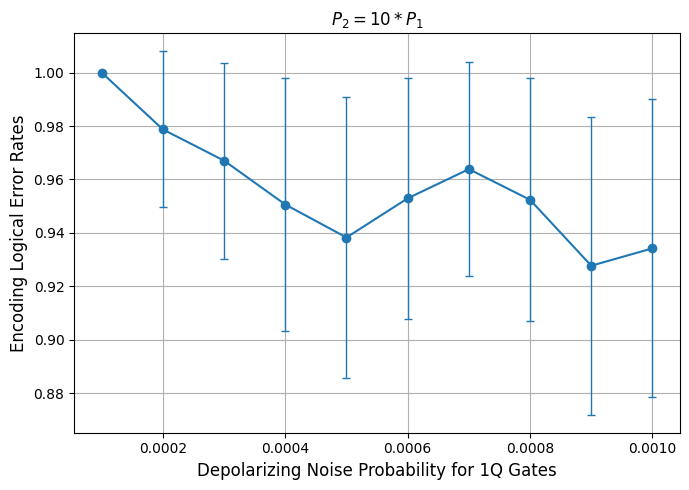

In [47]:
plt.figure(figsize=(7, 5))
plt.errorbar(
    err_rates,
    logical_error_rates,
    yerr=unc,
    fmt='o-',           # circle marker and solid line
    capsize=3,          # length of the little “T” caps on each bar
    elinewidth=1,       # width of the error‐bar lines
    markeredgewidth=1
)
plt.xlabel("Depolarizing Noise Probability for 1Q Gates", fontsize=12)
plt.ylabel("Encoding Logical Error Rates", fontsize=12)
plt.title(f"$P_2 = 10 * P_1$")
plt.grid(True)
plt.tight_layout()
#plt.yscale('log')
#plt.xscale('log')
plt.show()

# Logical Error Rate for Hadamard

In [ ]:
ideal = QuantumCircuit(7)
perfect_encoding(ideal, 0)
for i in range(7):
    ideal.append(H_custom, [i])
ideal = DensityMatrix(ideal)


err_rates = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]
logical_error_rates = []
unc = []

for p1 in err_rates:
    #################################################################################
    # Error model
    p2 = p1 * 10
    noise_model = NoiseModel()

    noise_model.add_all_qubit_quantum_error(depolarizing_error(p1,1), ['id'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p1,1), ['h'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p2,2), ['cx'])

    # 0.5% chance of flipping 0 <-> 1
    readout_err = ReadoutError([[1-p2, p2],  # P(measured 0 | actual 0), P(1 | 0)
                                [p2, 1-p2]]) # P(0 | 1), P(1 | 1)

    # Apply to all qubits being measured
    noise_model.add_readout_error(readout_err, [7]) 
    noise_model.add_readout_error(readout_err, [8])
    noise_model.add_readout_error(readout_err, [9])
    noise_model.add_readout_error(readout_err, [10])
    noise_model.add_readout_error(readout_err, [11])
    noise_model.add_readout_error(readout_err, [12])
    noise_model.add_readout_error(readout_err, [13])
    #################################################################################
    # Encoding + 1 Round of EC and running shots
    qc = QuantumCircuit(14)

    c = ClassicalRegister(6, "c")
    c1 = ClassicalRegister(7, "c1")
    c2 = ClassicalRegister(7, "c2")

    qc.add_register(c, c1, c2)

    encoding(qc, 0)
    for i in range(7):
        qc.h(i)
    QEC(qc, 0, c, c1, c2)

    qc.save_statevector(label='statevector_post', pershot=True, conditional=True)

    backend = AerSimulator(noise_model=noise_model)
    transpiled = transpile(qc, backend, optimization_level=0)
    job = backend.run(transpiled, shots=1000, memory=True)
    result = job.result()
    memory = result.get_memory()
    #################################################################################
    # Create array with keys (hex results) and values (statevectors)
    hex_to_sv = []
    hex_mem = result.data()['memory']

    seen = defaultdict(int)
    for mem in hex_mem:
        idx = seen[mem]
        val = result.data()['statevector_post'][mem][idx]
        hex_to_sv.append({mem:val})
        seen[mem] += 1
    #################################################################################
    # Apply corrections to each statevector in above array
    sv_correction = []
    for i, result in enumerate(hex_to_sv):
        hex, sv14 = next(iter(result.items()))
        correction_x, correction_z = lookup(memory[i])
        if (correction_x is None or correction_z is None):
            continue
        correction_z = "I"*7 + correction_z[::-1]
        correction_x = "I"*7 + correction_x[::-1]
        Pauli_cz = Pauli(correction_z)
        Pauli_cx = Pauli(correction_x)
        sv14 = sv14.evolve(Pauli_cz)
        sv14 = sv14.evolve(Pauli_cx)
        sv_correction.append(sv14)
    #################################################################################
    # Count the correct outputs
    sum = 0
    for sv in sv_correction:
        sv = partial_trace(sv, [7, 8, 9, 10, 11, 12, 13])
        if (np.round(state_fidelity(sv, ideal)) == 1.0):
            sum += 1
    #################################################################################
    # Computing uncertainty and add to uncertainty array
    num_meas = len(sv_correction)
    error_rate = sum / num_meas
    unc.append(1.96 * np.sqrt( (error_rate * (1 - error_rate) / num_meas) ))
    #################################################################################
    # Add logical error rate to resulting array
    logical_error_rates.append(sum / len(sv_correction))

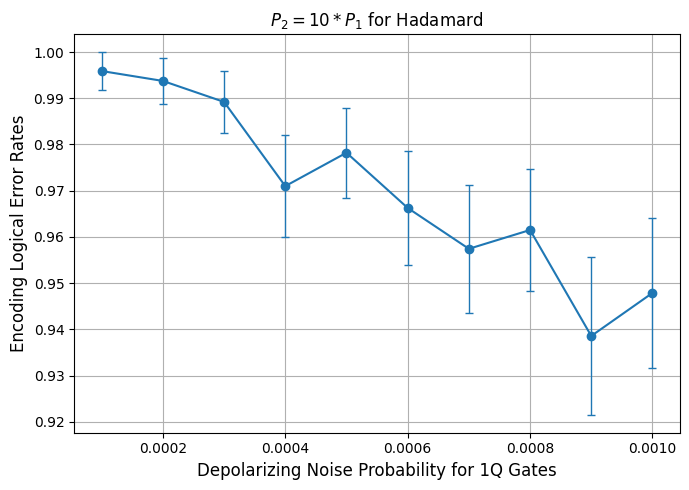

In [ ]:
plt.figure(figsize=(7, 5))
plt.errorbar(
    err_rates,
    logical_error_rates,
    yerr=unc,
    fmt='o-',           # circle marker and solid line
    capsize=3,          # length of the little “T” caps on each bar
    elinewidth=1,       # width of the error‐bar lines
    markeredgewidth=1
)
plt.xlabel("Depolarizing Noise Probability for 1Q Gates", fontsize=12)
plt.ylabel("Encoding Logical Error Rates", fontsize=12)
plt.title(f"$P_2 = 10 * P_1$ for Hadamard")
plt.grid(True)
plt.tight_layout()
#plt.yscale('log')
#plt.xscale('log')
plt.show()

# Logical Error Rate for CZ

In [12]:
noise_model = NoiseModel()

noise_model.add_all_qubit_quantum_error(depolarizing_error(0.0005,1), ['id'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.0005,1), ['h'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.005,2), ['cx'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.005,2), ['cz'])

# 0.5% chance of flipping 0 <-> 1
readout_err = ReadoutError([[0.995, 0.005],  # P(measured 0 | actual 0), P(1 | 0)
                            [0.005, 0.995]]) # P(0 | 1), P(1 | 1)

# Apply to all qubits being measured
noise_model.add_readout_error(readout_err, [7]) 
noise_model.add_readout_error(readout_err, [8])
noise_model.add_readout_error(readout_err, [9])
noise_model.add_readout_error(readout_err, [10])
noise_model.add_readout_error(readout_err, [11])
noise_model.add_readout_error(readout_err, [12])
noise_model.add_readout_error(readout_err, [13])
noise_model.add_readout_error(readout_err, [14])
noise_model.add_readout_error(readout_err, [15])
noise_model.add_readout_error(readout_err, [16])
noise_model.add_readout_error(readout_err, [17])
noise_model.add_readout_error(readout_err, [18])
noise_model.add_readout_error(readout_err, [19])
noise_model.add_readout_error(readout_err, [20])
noise_model.add_readout_error(readout_err, [21])
noise_model.add_readout_error(readout_err, [22])
noise_model.add_readout_error(readout_err, [23])

QEC Function for two blocks

In [13]:
def QEC2part(qc: QuantumCircuit, first_qubit1: int, first_qubit2: int, c: ClassicalRegister, c1: ClassicalRegister, c2: ClassicalRegister, s: ClassicalRegister, s1: ClassicalRegister, s2: ClassicalRegister):
    flag(qc, first_qubit1, c)
    qc.reset([first_qubit1+7, first_qubit1+8, first_qubit1+9, first_qubit1+10, first_qubit1+11, first_qubit1+12])
    
    # Path 1: if c is all 0, then do nothing
    path1 = QuantumCircuit(28)
    path1.add_register(c, c1, c2, s, s1, s2)
    # Path 2: if c is anything else
    path2 = QuantumCircuit(28)
    path2.add_register(c, c1, c2, s, s1, s2)
    unflag(path2, first_qubit1, c1, c2)
    
    first_if = IfElseOp((c, 0), true_body=path1, false_body=path2)
    qc.append(first_if, list(range(28)), c[:] + c1[:] + c2[:] + s[:] + s1[:] + s2[:])
    
    #########################
    
    flag(qc, first_qubit2, s)
    qc.reset([first_qubit2+7, first_qubit2+8, first_qubit2+9, first_qubit2+10, first_qubit2+11, first_qubit2+12])
    
    # Path 3: if s is all 0, then do nothing
    path3 = QuantumCircuit(28)
    path3.add_register(c, c1, c2, s, s1, s2)
    # Path 4: if s is anything else
    path4 = QuantumCircuit(28)
    path4.add_register(c, c1, c2, s, s1, s2)
    unflag(path4, first_qubit2, s1, s2)
    
    second_if = IfElseOp((s, 0), true_body=path3, false_body=path4)
    qc.append(second_if, list(range(28)), c[:] + c1[:] + c2[:] + s[:] + s1[:] + s2[:])

In [14]:
qc = QuantumCircuit(28)

c = ClassicalRegister(6, "c")
c1 = ClassicalRegister(7, "c1")
c2 = ClassicalRegister(7, "c2")

s = ClassicalRegister(6, "s")
s1 = ClassicalRegister(7, "s1")
s2 = ClassicalRegister(7, "s2")

qc.add_register(c, c1, c2, s, s1, s2)

encoding(qc, 0)
encoding(qc, 14)
for i in range(7):
    qc.cz(i, i+14)
QEC2part(qc, 0, 14, c, c1, c2, s, s1, s2)

qc.save_statevector(label='statevector_post', pershot=True, conditional=True)

backend = AerSimulator(noise_model=noise_model)
transpiled = transpile(qc, backend, optimization_level=0)
job = backend.run(transpiled, shots=50, memory=True)
result = job.result()
memory = result.get_memory()

#print(result)
print(memory)

['0000000 0000000 000000 0000000 1111110 011000', '0000000 0000000 000000 0000111 0110011 010000', '0000000 0000000 000000 0000000 1010010 000100', '0000000 0000000 000000 0000000 0000000 000000', '1010010 0110110 000100 1100100 1010010 100100', '0000000 0000000 000000 0000000 0000000 000000', '0000000 0000000 000000 0000000 0000000 000000', '0000000 0000000 000000 0000000 0000000 000000', '0000000 0000000 000000 0000000 0000000 000000', '0000000 0000000 000000 0000000 0000000 000000', '0000000 0000000 000000 0000000 0000000 000000', '0000000 0000000 000000 0110100 0100000 100000', '0000000 0000000 000000 0000000 0000000 000000', '0000000 0000000 000000 0000000 0000000 000000', '0000000 0000000 000000 0000000 0000000 000000', '0101010 0000011 001100 0011101 1100110 100001', '1001011 1100110 000010 0000000 0000000 000000', '0000000 0000000 000000 0000000 0000000 000000', '0000000 0000000 000000 0000000 0000000 000000', '0000000 0000000 000000 0011001 0111001 011000', '0000000 0000000 00

In [15]:
hex_to_sv = []
hex_mem = result.data()['memory']

seen = defaultdict(int)
for mem in hex_mem:
    idx = seen[mem]
    val = result.data()['statevector_post'][mem][idx]
    hex_to_sv.append({mem:val})
    seen[mem] += 1
    
sv_correction = []
for i, result in enumerate(hex_to_sv):
    hex, sv28 = next(iter(result.items()))
    b1_cx, b1_cz, b2_cx, b2_cz = transversal_cz_lookup(memory[i])
    if (b1_cx is None or b1_cz is None or b2_cx is None or b2_cz is None):
        continue
    cz = b1_cz[::-1] + "I"*7 + b2_cz[::-1] + "I"*7
    cx = b1_cx[::-1] + "I"*7 + b2_cx[::-1] + "I"*7
    for i, correction in enumerate(cz):
        if (correction == "Z"):
            sv28.evolve(ZGate(), [i])
    for i, correction in enumerate(cx):
        if (correction == "X"):
            sv28.evolve(XGate(), [i])
    sv_correction.append(sv28)

In [16]:
print(len(sv_correction))

35


In [17]:
ideal = QuantumCircuit(28)
perfect_encoding(ideal, 0)
perfect_encoding(ideal, 14)
for i in range(7):
    ideal.append(CZ_custom, [i, i+14])
ideal = Statevector(ideal)

In [ ]:
for sv in sv_correction:
    sv = partial_trace(sv, [7, 8, 9, 10, 11, 12, 13, 21, 22, 23, 24, 25, 26, 27])

In [18]:
sum = 0
for sv in sv_correction:
    if (sv == ideal):
        sum += 1

In [25]:
print(sum)

29


In [ ]:
logical_error_rate_cz = sum / len(sv_correction)

In [ ]:
ideal = QuantumCircuit(28)
perfect_encoding(ideal, 0)
perfect_encoding(ideal, 14)
for i in range(7):
    ideal.append(CZ_custom, [i, i+14])
ideal = Statevector(ideal)


err_rates = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]
logical_error_rates = []
unc = []

for p1 in err_rates:
    #################################################################################
    # Error model
    p2 = p1 * 10
    noise_model = NoiseModel()

    noise_model.add_all_qubit_quantum_error(depolarizing_error(p1,1), ['id'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p1,1), ['h'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p2,2), ['cx'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p2,2), ['cz'])

    # 0.5% chance of flipping 0 <-> 1
    readout_err = ReadoutError([[1-p2, p2],  # P(measured 0 | actual 0), P(1 | 0)
                                [p2, 1-p2]]) # P(0 | 1), P(1 | 1)

    # Apply to all qubits being measured
    noise_model.add_readout_error(readout_err, [7]) 
    noise_model.add_readout_error(readout_err, [8])
    noise_model.add_readout_error(readout_err, [9])
    noise_model.add_readout_error(readout_err, [10])
    noise_model.add_readout_error(readout_err, [11])
    noise_model.add_readout_error(readout_err, [12])
    noise_model.add_readout_error(readout_err, [13])
    noise_model.add_readout_error(readout_err, [14])
    noise_model.add_readout_error(readout_err, [15])
    noise_model.add_readout_error(readout_err, [16])
    noise_model.add_readout_error(readout_err, [17])
    noise_model.add_readout_error(readout_err, [18])
    noise_model.add_readout_error(readout_err, [19])
    noise_model.add_readout_error(readout_err, [20])
    noise_model.add_readout_error(readout_err, [21])
    noise_model.add_readout_error(readout_err, [22])
    noise_model.add_readout_error(readout_err, [23])
    #################################################################################
    # Encoding + 1 Round of EC and running shots
    qc = QuantumCircuit(28)

    c = ClassicalRegister(6, "c")
    c1 = ClassicalRegister(7, "c1")
    c2 = ClassicalRegister(7, "c2")

    s = ClassicalRegister(6, "s")
    s1 = ClassicalRegister(7, "s1")
    s2 = ClassicalRegister(7, "s2")

    qc.add_register(c, c1, c2, s, s1, s2)

    encoding(qc, 0)
    encoding(qc, 14)
    for i in range(7):
        qc.cz(i, i+14)
    QEC2part(qc, 0, 14, c, c1, c2, s, s1, s2)

    qc.save_statevector(label='statevector_post', pershot=True, conditional=True)

    backend = AerSimulator(noise_model=noise_model)
    transpiled = transpile(qc, backend, optimization_level=0)
    job = backend.run(transpiled, shots=30, memory=True)
    result = job.result()
    memory = result.get_memory()
    #################################################################################
    # Create array with keys (hex results) and values (statevectors)
    hex_to_sv = []
    hex_mem = result.data()['memory']

    seen = defaultdict(int)
    for mem in hex_mem:
        idx = seen[mem]
        val = result.data()['statevector_post'][mem][idx]
        hex_to_sv.append({mem:val})
        seen[mem] += 1
    #################################################################################
    # Apply corrections to each statevector in above array
    sv_correction = []
    for i, result in enumerate(hex_to_sv):
        hex, sv28 = next(iter(result.items()))
        b1_cx, b1_cz, b2_cx, b2_cz = transversal_cz_lookup(memory[i])
        if (b1_cx is None or b1_cz is None or b2_cx is None or b2_cz is None):
            continue
        cz = b1_cz[::-1] + "I"*7 + b2_cz[::-1] + "I"*7
        cx = b1_cx[::-1] + "I"*7 + b2_cx[::-1] + "I"*7
        for i, correction in enumerate(cz):
            if (correction == "Z"):
                sv28.evolve(ZGate(), [i])
        for i, correction in enumerate(cx):
            if (correction == "X"):
                sv28.evolve(XGate(), [i])
        sv_correction.append(sv28)
    #################################################################################
    # Count the correct outputs
    sum = 0
    for sv in sv_correction:
        sv = partial_trace(sv, [7, 8, 9, 10, 11, 12, 13, 21, 22, 23, 24, 25, 26, 27])
        if (sv == ideal):
            sum += 1
    #################################################################################
    # Computing uncertainty and add to uncertainty array
    num_meas = len(sv_correction)
    error_rate = sum / num_meas
    unc.append(1.96 * np.sqrt( (error_rate * (1 - error_rate) / num_meas) ))
    #################################################################################
    # Add logical error rate to resulting array
    logical_error_rates.append(sum / len(sv_correction))

In [ ]:
plt.figure(figsize=(7, 5))
plt.errorbar(
    err_rates,
    logical_error_rates,
    yerr=unc,
    fmt='o-',           # circle marker and solid line
    capsize=3,          # length of the little “T” caps on each bar
    elinewidth=1,       # width of the error‐bar lines
    markeredgewidth=1
)
plt.xlabel("Depolarizing Noise Probability for 1Q Gates", fontsize=12)
plt.ylabel("Encoding Logical Error Rates", fontsize=12)
plt.title(f"$P_2 = 10 * P_1$ for Hadamard")
plt.grid(True)
plt.tight_layout()
#plt.yscale('log')
#plt.xscale('log')
plt.show()